In [1]:
%pip install matplotlib seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
data = pd.read_csv('../data/clean-data/sf_clean_data_grouped.csv')
data.head()

Note: you may need to restart the kernel to use updated packages.


,Incident Number,Incident Datetime,Incident Category,Incident Description,Police District,Resolution,Latitude,Longitude,Incident Day of Week,Year,Focus Group
0,160204156,2016-03-03 19:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Taraval,NONE,37.707968,-122.463545,Thursday,2016,Property Crime
1,130119109,2013-02-10 18:09:00,ASSAULT,BATTERY,Mission,NONE,37.754222,-122.425237,Sunday,2013,Violent Crime
2,61026720,2006-09-25 22:15:00,ASSAULT,BATTERY,Northern,NONE,37.778486,-122.425839,Monday,2006,Violent Crime
3,110493133,2011-06-19 13:06:00,TRESPASS,TRESPASSING,Taraval,NONE,37.729185,-122.466758,Sunday,2011,Property Crime
4,80749068,2008-05-23 12:10:00,ASSAULT,BATTERY,Northern,NONE,37.775904,-122.423582,Friday,2008,Violent Crime


In [2]:
data.columns

Index(['Incident Number', 'Incident Datetime', 'Incident Category',
       'Incident Description', 'Police District', 'Resolution', 'Latitude',
       'Longitude', 'Incident Day of Week', 'Year', 'Focus Group'],
      dtype='str')

---
## Assignment 1.4: Spatial Power Law

Is crime spread evenly across San Francisco, or is it concentrated in a small number of hotspots? Let's find out.

Use your **most common Personal Focus Crime** (by total incident count) for this exercise.

> * **Step 1**: Divide San Francisco into a grid of approximately $100\text{m} \times 100\text{m}$ cells using latitude and longitude. It is fine to ignore that the Earth isn't flat — the approximation is good enough for this purpose.
>     * **Hint**: `np.histogram2d` works well here. Focus on points within the SF peninsula; filter out geographic outliers.
> * **Step 2**: Count the number of incidents of your chosen crime in each grid cell (use all years of data).
> * **Step 3**: Tally the distribution. Count how many cells have exactly $k$ incidents — call this $N(k)$ — for $k = 0, 1, 2, \ldots$ up to the maximum.
> * **Step 4**: Plot $(k+1)$ vs $N(k)$ on **linear axes**.
> * **Step 5**: Plot $(k+1)$ vs $N(k)$ on **loglog axes**.

### Plotting

Analyzing most common crime: Property Crime


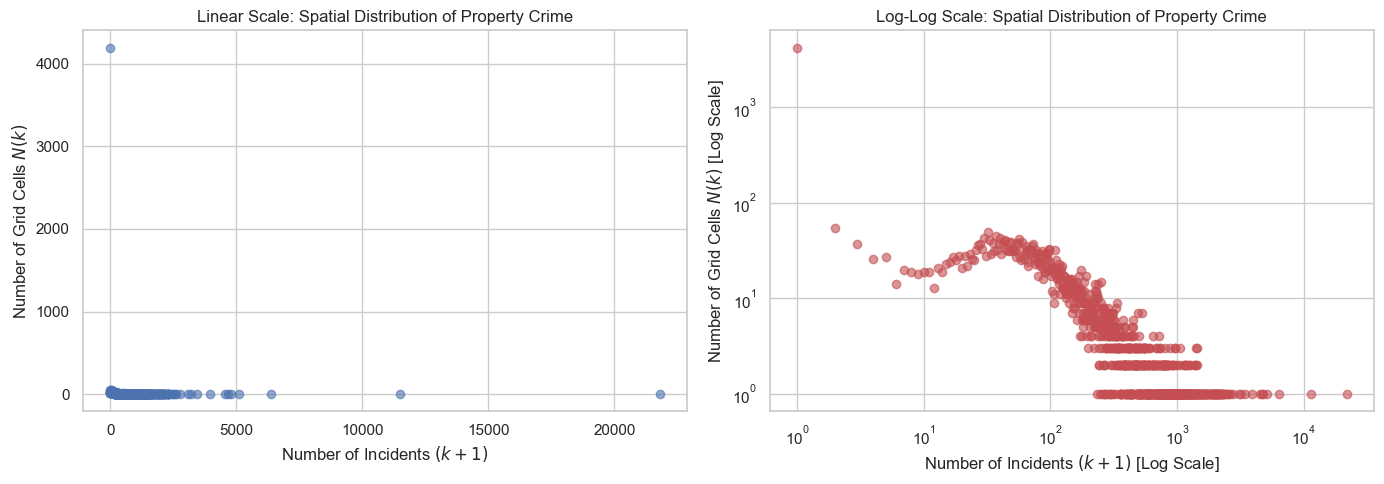

In [11]:
# Clean up any potential NaNs in coordinates
data = data.dropna(subset=['Latitude', 'Longitude'])
data = data[data['Latitude'] < 90]
data = data[data['Longitude'] < 90]

# Find the most common incident category
top_crime_name = data['Focus Group'].value_counts().idxmax()
print(f"Analyzing most common crime: {top_crime_name}")

# Filter for the top crime
df_top = data[data['Focus Group'] == top_crime_name]

# --- Step 1 & 2: Grid and Count ---
# Filter for the SF Peninsula to avoid geographic outliers
# Approximate SF Bounds: Lat [37.70, 37.82], Lon [-122.52, -122.35]
sf_mask = (df_top['Latitude'] > 37.70) & (df_top['Latitude'] < 37.82) & \
          (df_top['Longitude'] > -122.52) & (df_top['Longitude'] < -122.35)
df_filtered = df_top[sf_mask]

# Create ~100m bins (110 bins for ~11km span)
counts, xedges, yedges = np.histogram2d(
    df_filtered['Longitude'], 
    df_filtered['Latitude'], 
    bins=[100, 100]
)

# Flatten the 2D array to get a 1D list of incident counts per cell
cell_counts = counts.flatten()

# --- Step 3: Tally the Distribution N(k) ---
# np.unique with return_counts=True perfectly calculates N(k) for each k
k_values, n_k = np.unique(cell_counts, return_counts=True)

# --- Plotting ---
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear Plot (Step 4)
ax1.plot(k_values + 1, n_k, marker='o', linestyle='none', alpha=0.6, color='b')
ax1.set_title(f"Linear Scale: Spatial Distribution of {top_crime_name.title()}")
ax1.set_xlabel("Number of Incidents $(k+1)$")
ax1.set_ylabel("Number of Grid Cells $N(k)$")

# Log-Log Plot (Step 5)
ax2.loglog(k_values + 1, n_k, marker='o', linestyle='none', alpha=0.6, color='r')
ax2.set_title(f"Log-Log Scale: Spatial Distribution of {top_crime_name.title()}")
ax2.set_xlabel("Number of Incidents $(k+1)$ [Log Scale]")
ax2.set_ylabel("Number of Grid Cells $N(k)$ [Log Scale]")

plt.tight_layout()
plt.show()

### Analysis
> * **Step 6**: Does your crime follow a power-law spatial distribution? How can you tell from the loglog plot?


Seeing that the plot follows the data points form a downward-spiralling funnel, we can say that the distribution **follows power-law distribution**. <br>
According to [online statistics portal](https://www.statisticshowto.com/power-law/), the power law can be used to describe a phenomen where a small number of items is clustered at the top/bottom of distribution, taking up maximum of the resources. A good example of this is **wealth distribution** or **earthquakes**. In our case it means that it's fair to assume that crime is highly concentrated to small places. 

> * **Step 7**: If crime is spatially concentrated in a small number of cells, what does that imply for how we interpret neighborhood-level crime statistics? Does the "average block" tell you anything useful?


In short, the **power-law distribution proves that we can't average crime across the entire San Francisco**. There is no such thing as an "average block" - crime isn't evenly spread out through the entire city, it's centered on hotspots. In case of theft it could be equally tourist landmarks, places where a lot of people congregate at the same time (train/bus stations) or shops.


#### Analysis regarding The Outlier


There  is one suspicious outlier in the far left corner that seems to have 0 levels of crime. So let's find it!

--- Top Spatial Outlier Found ---
Location: 37.77568, -122.40286
Total Incidents in this 100m block: 21799


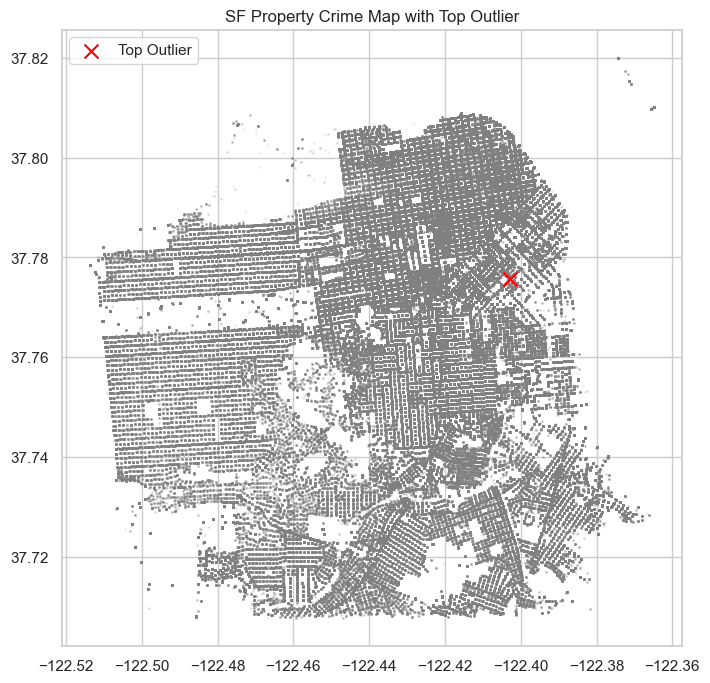

In [13]:
# 1. Find the index of the cell with the highest count
max_idx = np.unravel_index(np.argmax(counts, axis=None), counts.shape)

# 2. Convert that grid index back into Lat/Lon coordinates 
# We take the average of the edges to get the center of the 100m square
lon_outlier = (xedges[max_idx[0]] + xedges[max_idx[0] + 1]) / 2
lat_outlier = (yedges[max_idx[1]] + yedges[max_idx[1] + 1]) / 2
max_incidents = counts[max_idx]

print(f"--- Top Spatial Outlier Found ---")
print(f"Location: {lat_outlier:.5f}, {lon_outlier:.5f}")
print(f"Total Incidents in this 100m block: {int(max_incidents)}")

# 3. Quick Plot to see it on a scatter map
plt.figure(figsize=(8, 8))
plt.scatter(df_filtered['Longitude'], df_filtered['Latitude'], s=1, alpha=0.1, color='gray')
plt.scatter(lon_outlier, lat_outlier, color='red', s=100, marker='x', label='Top Outlier')
plt.title(f"SF {top_crime_name.title()} Map with Top Outlier")
plt.legend()
plt.show()

If we enter these coordinates to Google Maps we are transported to Bryant Street - right next to **San Francisco Police Officer's Association** (a non-profit organization for past and current police officers in San Francisco), which is next to **Hall of Justice** and of course - across the street from **San Francisco police department**. It makes sense this outlier would be a quiet spot, where no crime occurs. 
